In [1]:
%pylab inline
from IPython.display import Audio
import librosa
import scipy as sp
from numba import jit
from scipy.spatial import distance

figsize(20,6)
prefix="baseline"
def filepre(nm):
    return "tmp/"+prefix+"_"+nm
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


In [74]:
# %load_ext autoreload
# %autoreload 1

# %aimport microbial

In [2]:
sr = 22050
def nrmse(output,target):
    assert(output.shape[0] == target.shape[0])
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = max(abs(np.linalg.eig(internalWeights)[0]))
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

pLoop = lambda n,p: p[n%p.size]

In [3]:
from datetime import datetime
import os
resultsFolderName = "csynthResults/results" + str(datetime.now()) + "/"
os.mkdir(resultsFolderName)


In [4]:
# relevant_path = "audios/ixi"
# ixiFiles = [fn for fn in os.listdir(relevant_path)
#               if fn.endswith('wav')]
ixiFiles = ['909a_22k.wav']
print(ixiFiles)


['909a_22k.wav']


In [5]:
def ixistr(id):
    return str(id) + "_" + ixiFiles[id] + "_"

In [6]:
def compareMFCCs(seq1, seq2):
    fftSize=2048
    hop=64    
    melspec = librosa.feature.melspectrogram(y=seq1, sr=sr, n_fft=fftSize,hop_length=hop)
    mfccs = librosa.feature.mfcc(S=melspec,n_mfcc=20)[1:,:]
    melspec2 = librosa.feature.melspectrogram(y=seq2, sr=sr, n_fft=fftSize,hop_length=hop)
    mfccs2 = librosa.feature.mfcc(S=melspec2,n_mfcc=20)[1:,:]    
    return nrmse(mfccs.flatten(), mfccs2.flatten())

In [7]:
def computeConceptor(p, net, i_pattern, alpha):
    print('Computing conceptor, alpha: ', alpha)
#     Cs = np.zeros((4, 1), dtype=np.object)
    R = net['patternRs'][0,i_pattern]
    [U,s,V] = svd(R)
    S = diag(s)
    Snew = (S.dot(linalg.inv(S + pow(alpha, -2) * np.eye(p['N']))))

    C =  U.dot(Snew).dot(U.T);
#     Cs[0,0] = C
#     Cs[1,0] = U
#     Cs[2,0] = diag(Snew)
#     Cs[3,0] = diag(S)

    return C


def testConceptor(p, C, net, recallTestLength):
    trials = 1
    attens = np.zeros(trials)
#     LR = np.diag(p['LR'])
#     LROneMinus = np.diag(1.0 - p['LR'])
    LR = array(p['LR'])
    LROneMinus = array(1.0 - p['LR'])
    for i_trial in range(trials):
        x_CTestPL = np.zeros((p['N'], recallTestLength))
        z_CTestPL = np.zeros((p['N'], recallTestLength))
        x = 0.5 * np.random.randn(p['N'],1)
        z = x
        for n in range(recallTestLength + p['washoutLength']):
            xOld = x
            Wtarget = (net['W'].dot(x))
            leakTerm = LROneMinus.dot(xOld)
            newX =tanh(Wtarget + net['Wbias'])
            newXLeaked = LR.dot(newX)
            z = leakTerm + newXLeaked
            x = C.dot(z)
#             xPrev = x
            if (n > p['washoutLength']):
                x_CTestPL[:,n-p['washoutLength']] = x.T
                z_CTestPL[:,n-p['washoutLength']] = z.T

        attenuation = np.mean(pow(np.linalg.norm(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.linalg.norm(z_CTestPL[:,:], axis=1),2))
        attens[i_trial] = attenuation
        
    return np.mean(attens)


In [8]:
def makeLoadedNetwork_v2(p):
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
    WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
#     xCollector = np.zeros((p['N'], p['learnLength']))
#     pCollector = np.zeros((1, p['learnLength']))
    x = np.zeros((p['N'],1))
    
    allTrainxArgs = np.zeros((p['N'] + 1, 0));
    allTrainOldxArgs = np.zeros((p['N'], 0));
    allTrainWtargets = np.zeros((p['N'], 0));
    allTrainOuts = np.zeros((1, 0));
    patternRs =  np.zeros((1, p['patts'].shape[0]), dtype=np.object)
    print('Loading patterns: ', end='')
#     LR = np.diag(p['LR'])
#     LROneMinus = np.diag(1.0 - p['LR'])
    LR = array(p['LR'])
    LROneMinus = array(1.0 - p['LR'])
#     print(LR)
#     print(LROneMinus)
    for i_pattern in range(p['patts'].shape[0]):
        print(i_pattern, " ", end='')
        patt = p['patts'][i_pattern]
        pattLearnLen = patt.size * p['learnLength']
        xCollector = np.zeros((p['N'] + 1, pattLearnLen));
        xOldCollector = np.zeros((p['N'], pattLearnLen));
        WTargetCollector = np.zeros((p['N'], pattLearnLen));
        pCollector = np.zeros((1, pattLearnLen));
        x = np.zeros((p['N'], 1));

        for n in range(p['washoutLength'] + pattLearnLen):
            u = patt.take(n, mode='wrap')
            xOld = x
            Wtarget = (Wstar.dot(x)) + (Win.dot(u))
            leakTerm = LROneMinus.dot(xOld)
            newX =tanh(Wtarget + Wbias)
            newXLeaked = LR.dot(newX)
            x = leakTerm + newXLeaked

            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                pCollector[0, n - p['washoutLength']] = u
                
            uOld = u
        
        R = xCollector[0:-1].dot(xCollector[0:-1].T) / pattLearnLen
        patternRs[0,i_pattern] = R
        allTrainxArgs = np.concatenate((allTrainxArgs, xCollector), axis=1)
        allTrainOldxArgs = np.concatenate((allTrainOldxArgs, xOldCollector), axis=1)
        allTrainOuts = np.concatenate((allTrainOuts, pCollector), axis=1)
        allTrainWtargets = np.concatenate((allTrainWtargets, WTargetCollector), axis=1)


    Wout = (linalg.inv(allTrainxArgs.dot(allTrainxArgs.conj().T) +
                      (p['TychonovAlphaReadout'] * np.eye(p['N'] + 1))).dot(allTrainxArgs).dot(allTrainOuts.conj().T)).conj().T

    outsRecovered = Wout.dot(allTrainxArgs);
    NRMSE_readout = mean(nrmse(outsRecovered, allTrainOuts))
    absSize_readout = mean(mean(abs(Wout), axis=0))
    print("\nNRMSE readout: ", NRMSE_readout, " :: ", end='')
    print("absSize readout: ", absSize_readout)
    
    W = (linalg.inv(allTrainOldxArgs.dot(allTrainOldxArgs.conj().T) +
                      (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldxArgs).dot(allTrainWtargets.conj().T)).conj().T
    NRMSE_W = mean(nrmse(W.dot(allTrainOldxArgs), allTrainWtargets))
    absSize_W = mean(mean(abs(W), axis=0))
    print("NRMSE W: ", NRMSE_W, " :: ", end='')
    print("absSize W: ", absSize_W)

    data ={k: v for k, v in locals().items() if k in 
           ('p','Win','Wstar', 'Wbias','NRMSE_W', 'absSize_W','patternRs','W',
            'Wout','NRMSE_readout', 'absSize_readout')}
    return data

In [9]:

def render(p, patternCs, bestNet, lrMod=1.0, speed=1.0, xFade=0.05, srMod=1):
    audio = np.zeros(0)
    x = 0.5 * np.random.randn(p['N'],1)
    C = patternCs[0]
    
    LR = p['LR']
    LR = array(LR * lrMod)
    LROneMinus = array(1.0 - p['LR'])
    Wmod = bestNet['W'] * srMod
    
    #run to washout
    for n in range(p['washoutLength']):
        xOld = x
        Wtarget = (Wmod.dot(x))
        z = (LROneMinus.dot(xOld)) + (LR.dot(tanh(Wtarget + bestNet['Wbias'])))
        x = C.dot(z)


    for i_patt in range(p['patts'].shape[0]):
        xFadeTime=int(p['patts'][i_patt].shape[0] * xFade)
        for n in range(int(p['patts'][i_patt].shape[0] * speed)):
            C = patternCs[i_patt]
            v=int(p['patts'][i_patt].shape[0] * speed)
            stepL = min(v - n - 1, xFadeTime)
            stepU = min(n, xFadeTime)
            m1 = 1.0
            if(n > v-xFadeTime-1 and i_patt < p['patts'].shape[0]-1):
                m1 = (stepL + stepU) / (2*xFadeTime)
                nextC = patternCs[i_patt+1]
                C = (m1 * C) + ((1.0-m1) * nextC)
            else:
                if (n < xFadeTime and i_patt > 0):
                    m1 = 0.5 - (n / (2*xFadeTime))
                    prevC = patternCs[i_patt-1]
                    C = (m1 * prevC) + ((1.0-m1) * C)
#                 else:
#                     C = cNet['Cs'][0,0]
            
            xOld = x
            Wtarget = (Wmod.dot(x))
            z = (LROneMinus.dot(xOld)) + (LR.dot(tanh(Wtarget + bestNet['Wbias'])))
            x = C.dot(z)

            newSample = bestNet['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
            audio = np.concatenate((audio, newSample))
    return audio



In [10]:
def evalModel(genome, patterns, patternLengths, orgAudio, N=900):
    LR =genome[0]
    modelParams = {'N':N, 'NetSR':1.5, 'NetinpScaling':1.2,'BiasScaling':0.3, 'TychonovAlpha':0.0001,
             'washoutLength':50, 'learnLength':4, 'TychonovAlphaReadout':0.0001,
              'LR': LR,
              'patts':patterns
             }   
    newNetwork  = makeLoadedNetwork_v2(modelParams)
    
    import scipy
    def fitnessf(aperture, *args):
        print('Pattern: ', args[0])
        params = args[1]
        net = args[2]
        try:
            C = computeConceptor(params, net, args[0], aperture)
        except:
            return 999
        atten = testConceptor(params, C, net, params['patts'][args[0]].size * params['learnLength'])
        return atten

    apertures = [scipy.optimize.fminbound(fitnessf, 0,1000,  disp=2, xtol=15, args = (x,modelParams, newNetwork)) 
                 for x in np.arange(modelParams['patts'].shape[0])]

    #store conceptors with calculated apertures
    patternCs = np.zeros(len(apertures), dtype=np.object)
    for i_patt in range(patternCs.size):
        patternCs[i_patt] = computeConceptor(modelParams, newNetwork, i_patt, apertures[i_patt])
        
#     figsize(20,3)
    audio = render(modelParams, patternCs, newNetwork, 1.0,1.0, 0.05)
    error = compareMFCCs(audio, orgAudio)

#     plot(audio)
    return {"error":error, "waveform":audio, 'apertures':apertures, 'net':newNetwork}
#     plt.savefig(filepre('TwoRecon.pdf'))
#     librosa.output.write_wav(filepre("twoRecon.wav"), librosa.resample(audio, sr, 44100), 44100)
#     Audio(data=audio,rate=sr)        


In [11]:
def evalFitness(genome, data):

    modelData = evalModel(genome, data['patterns'], data['patternLengths'], data['orgAudio'], data['N'])
    if ("winner" in data):
        if modelData['error'] < data['winner']['error']:
            data['winner'] = modelData
    else:
        data['winner'] = modelData
    return modelData['error']


0:36:46.691288
Runtime: None
0 / 1  :  909a_22k.wav
[0.63502185 0.34583375 0.11817947 0.30028384 0.4683209  0.11732662
 0.2487437  0.1632119  0.20836699 0.        ]
hi res trial 9
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  
NRMSE readout:  0.0124745745973169  :: absSize readout:  0.02928236091128867
NRMSE W:  0.005084365444310596  :: absSize W:  0.030111976402458968
Pattern:  0
Computing conceptor, alpha:  381.9660112501051
Pattern:  0
Computing conceptor, alpha:  618.0339887498948
Pattern:  0
Computing conceptor, alpha:  236.0679774997897
Pattern:  0
Computing conceptor, alpha:  427.8957449168695
Pattern:  0
Computing conceptor, alpha:  376.9660055846336
Pattern:  0
Computing conceptor, alpha:  323.1477478040605
Pattern:  0
Computing conceptor, alpha:  350.7330062624684
Pattern:  0
Computing conceptor, alpha:  366.94589147041944
Pattern:  0
Computing conceptor, alpha:  371.96599999332415

Optimization terminated successfully;
The returned value

Pattern:  11
Computing conceptor, alpha:  376.9660055846336

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  15 )
Pattern:  12
Computing conceptor, alpha:  381.9660112501051
Pattern:  12
Computing conceptor, alpha:  618.0339887498948
Pattern:  12
Computing conceptor, alpha:  763.9320225002102
Pattern:  12
Computing conceptor, alpha:  854.1019662496844
Pattern:  12
Computing conceptor, alpha:  909.8300562505257
Pattern:  12
Computing conceptor, alpha:  849.101953581305
Pattern:  12
Computing conceptor, alpha:  859.1019789180639

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  15 )
Pattern:  13
Computing conceptor, alpha:  381.9660112501051
Pattern:  13
Computing conceptor, alpha:  618.0339887498948
Pattern:  13
Computing conceptor, alpha:  763.9320225002102
Pattern:  13
Computing conceptor, alpha:  583.582228968205
Pattern:  13
Computing conceptor, alpha:  623.0339979168

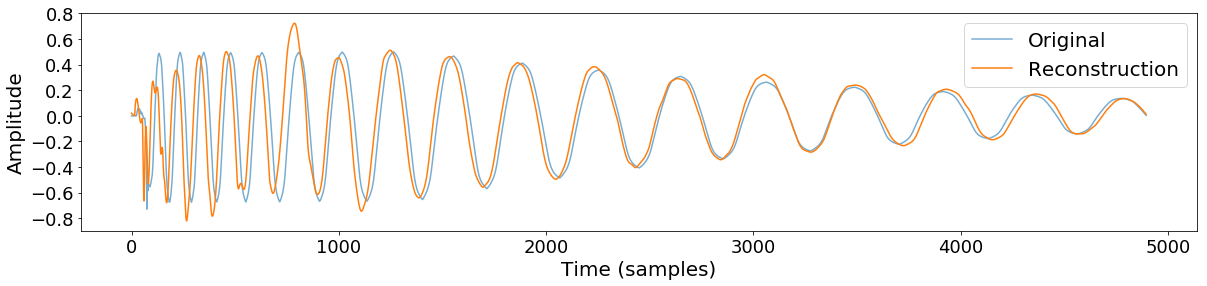

In [12]:
startTS = datetime.now()
testing = False
learningRates = linspace(0.05,0.95,10)
# for currentIxi in range(len(ixiFiles)):
for currentIxi in range(1) if testing else range(len(ixiFiles)):
    def log(msg):
        f = open(resultsFolderName + ixistr(currentIxi) + "searchLog.txt", "a")
        f.write(str(datetime.now()) + ":")
        f.write(msg)
        f.write('\r\n')
        f.close()  
        print(msg)
    clear_output()
    print("loading: ", ixiFiles[currentIxi])
    y, sr = librosa.load("audios/" + ixiFiles[currentIxi], sr=22050)
    y = y[:5000] / np.max(y) * 0.5
    print(sr)

    #divide out windows
    patterns = []

    minPatternSize = 9
    lastCrossing=0
    for i in range(y.shape[0]-1):
        if (i-lastCrossing) > minPatternSize and y[i] >=0 and y[i+1] < 0:
            print(i)
            segment = y[lastCrossing:i]
            patterns.append(segment)
            lastCrossing = i
            
    #convert to numpy
    patterns = np.array(patterns, dtype=np.object)
    maxPatterns = 150
    patterns = patterns[:maxPatterns]
    patternLengths = [x.shape[0] for x in patterns]
    y = y[:sum(patternLengths)]
    maxPatternLen = np.max(patternLengths)
    minPatternLen = np.min(patternLengths)
    print("max length: ", maxPatternLen)
    print("min length: ", minPatternLen)
    # for p in patterns:
    #     plot(p)
    print(patterns.shape)
    
    
    data = {'patterns':patterns, 'patternLengths':patternLengths, 'orgAudio':y}
    def onEpochStart():
        clear_output()
        print('Runtime:', print(datetime.now() - startTS))
        print(currentIxi, '/', len(ixiFiles), ' : ', ixiFiles[currentIxi])
        log(str(scores))

#     brute force search of learning rates
#     do the search at low res with smaller N
    data['N'] = 600
    scores = zeros_like(learningRates)
    for i,l in enumerate(learningRates):
        trials = 5
        trialScores = zeros(trials)
        for trial in range(trials):
            onEpochStart()
            log("lo res trial" + str(trial))
            log(str(scores))
            log(str(trialScores))
            trialScores[trial] = evalFitness(array([l]), data)
        scores[i] = np.median(trialScores)
        log(str(trialScores))
    
    winningScore = np.min(scores)
    log("Winning score: " + str(winningScore))
    bestLR = learningRates[np.argmin(scores)]
#     now generate the best of x at high res to find a good network
    data['N'] = 900
    trials = 10
    scores = zeros(trials)
    del data['winner']
    for trial in range(trials):
        onEpochStart()
        log("hi res trial " + str(trial))
        scores[trial] = evalFitness(array([bestLR]), data)
        log(str(scores))
        
        
    
#     microbial.evolve(pop, evalFitness, microbial.criterionMin, data, 3, 1 if testing else 15, 0.0, 1.0, 0.5 , onEpochStart)
    
    plt.close()
    figsize(20,4)
    plt.xlabel("Time (samples)", fontsize=20)
    plt.ylabel("Amplitude", fontsize=20)
    plt.xticks(fontsize=18, rotation=0)
    plt.yticks(fontsize=18, rotation=0) 
    plot(y, label='Original', alpha=0.6)
    plot(data['winner']['waveform'], alpha=1.0, label='Reconstruction')
    plt.legend(fontsize=20)
    plt.savefig(resultsFolderName + ixistr(currentIxi) + "compare.pdf", bbox_inches='tight')

    librosa.output.write_wav(resultsFolderName + ixistr(currentIxi) + "org.wav",y, sr)
    librosa.output.write_wav(resultsFolderName + ixistr(currentIxi) + "recon.wav", data['winner']['waveform'], sr)

    import dill as pickle
    with open(resultsFolderName + ixistr(currentIxi) + r"model.dill.pickled", "wb") as output_file:    
        pickle.dump({'winner':data['winner'], 'original':y, 'patterns':patterns}, output_file, protocol=0)


In [17]:
data['winner']['net']['p']

{'BiasScaling': 0.3,
 'LR': 0.15,
 'N': 900,
 'NetSR': 1.5,
 'NetinpScaling': 1.2,
 'TychonovAlpha': 0.0001,
 'TychonovAlphaReadout': 0.0001,
 'learnLength': 4,
 'patts': array([array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.8227856e-05, 2.8227856e-05, 2.8227856e-05,
        0.0000000e+00, 2.8227856e-05, 0.0000000e+00, 0.0000000e+00,
        2.8227856e-05, 0.0000000e+00, 2.8227856e-05, 0.0000000e+00],
       dtype=float32),
        array([ 5.64557122e-05, -5.64557122e-05,  8.46835683e-05, -8.46835683e-05,
         1.41139273e-04, -1.69367137e-04,  2.82278546e-04, -4.23417834e-04,
         1.72189914e-03,  1.27307624e-02,  2.37396266e-02,  3.28007676e-02,
         4.23135534e-02,  4.86365929e-02,  5.37176095e-02,  5.73872291e-02,
         5.97583689e-02,  5.97301424e-02,  5.85727990e-02,  5.78388758e-02,
         5.43950759e-02,  5.33224195e-02,  5.23908995e-02,  5.23062162e-02,
         4.89470996e-02,  3.92367207e-02,  2.83125397e-02,  2.45

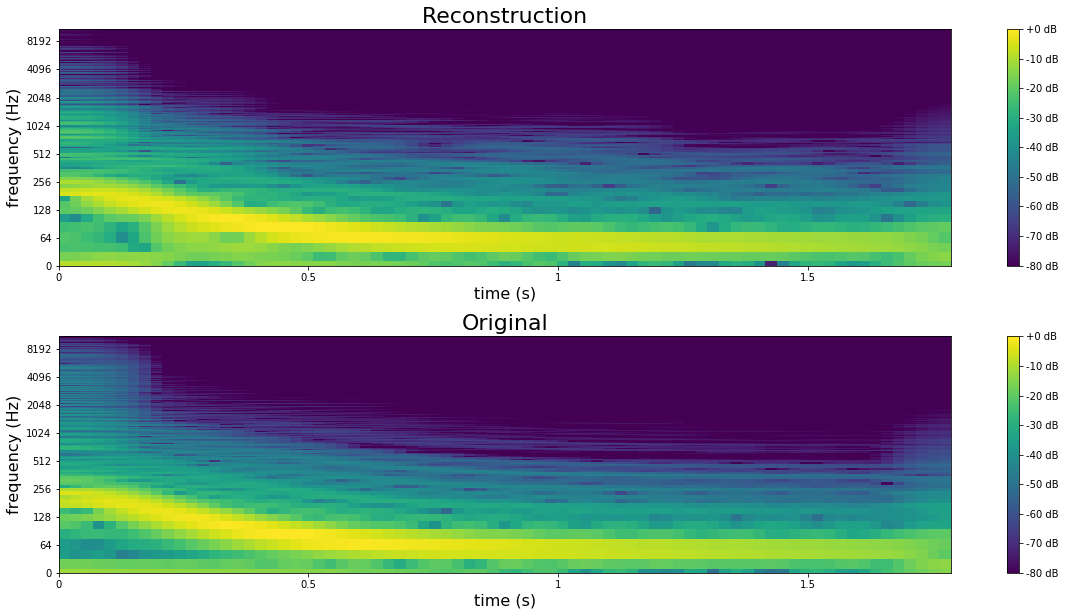

In [16]:
figsize(20,10)
import librosa.display
subplot(2,1,1)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
CQT = librosa.amplitude_to_db(np.abs(librosa.stft(data['winner']['waveform'], n_fft=1024, hop_length=64)), ref=np.max)
ax = librosa.display.specshow(CQT, x_axis='time', y_axis='log', sr=22050, cmap=plt.get_cmap('viridis'))
plt.colorbar(format='%+2.0f dB')
ax.set_ylabel("frequency (Hz)", fontsize=16)
ax.set_xlabel("time (s)", fontsize=16)
ax.set_title('Reconstruction', fontsize=22)

subplot(2,1,2)
CQT = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=1024, hop_length=64)), ref=np.max)
ax = librosa.display.specshow(CQT, x_axis='time', y_axis='log', sr=22050, cmap=plt.get_cmap('viridis'))
plt.colorbar(format='%+2.0f dB')
ax.set_title('Original', fontsize=22)
ax.set_ylabel("frequency (Hz)", fontsize=16)
ax.set_xlabel("time (s)", fontsize=16)
plt.savefig("tmp/kickSpectra.pdf", bbox_inches='tight')